In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import os

individual_counter = 0  

crossover_log = []

def save_population_to_file(population, generation, func):
    df = pd.DataFrame([
        {"generation": generation, "id": int(ind[0]), **{f"gene_{i}": ind[i+1] for i in range(len(ind)-1)}}
        for ind in population
    ])

    df.to_csv("population_log_GA_" + func + ".csv", mode="a", header=not os.path.exists("population_log_GA_" + func + ".csv"), index=False)

def initialize_population(pop_size, ind_size, bounds):
    global individual_counter
    population = []
    
    for _ in range(pop_size):
        genes = np.random.uniform(bounds[0], bounds[1], ind_size)
        population.append([individual_counter] + list(genes))
        individual_counter += 1
        
    return np.array(population)

def sphere(individual):
    return np.sum(np.square(individual[1:]))

def schwefel(individual):
    return 418.9829 * (len(individual) - 1) - np.sum(individual[1:] * np.sin(np.sqrt(np.abs(individual[1:]))))

def tournament_selection(population, fitnesses, k=3):
    selected = np.random.choice(len(population), k, replace=False)
    best = selected[np.argmin(fitnesses[selected])]
    return population[best]

def arithmetic_crossover(parent1, parent2):
    global individual_counter, crossover_log
    child1 = np.copy(parent1)
    child2 = np.copy(parent2)

    child1_id = individual_counter
    individual_counter += 1
    child2_id = individual_counter
    individual_counter += 1

    crossover_log.append([parent1[0], parent2[0], child1_id, child2_id])

    child1[0] = child1_id
    child2[0] = child2_id
    
    child1[1:] = 0.6 * parent1[1:] + 0.4 * parent2[1:]
    child2[1:] = 0.4 * parent2[1:] + 0.6 * parent1[1:]
    
    return child1, child2

def mutate(individual, mutation_rate, bounds):
    for i in range(1, len(individual)):
        if random.random() < mutation_rate:
            individual[i] = random.uniform(bounds[0], bounds[1])
    return individual

def evolve_population(population, elite_size, mutation_rate, fitness_func, bounds):
    fitnesses = np.array([fitness_func(ind) for ind in population])
    sorted_indices = np.argsort(fitnesses)
    
    new_population = population[sorted_indices][:elite_size]

    while len(new_population) < len(population):
        parent1 = tournament_selection(population, fitnesses)
        parent2 = tournament_selection(population, fitnesses)
        
        child1, child2 = arithmetic_crossover(parent1, parent2)
        child1 = mutate(child1, mutation_rate, bounds)
        child2 = mutate(child2, mutation_rate, bounds)
        
        new_population = np.vstack((new_population, child1, child2))

    return new_population[:len(population)]

def run_ga(pop_size, ind_size, generations, elite, mutation_rate, fitness_func, bounds):
    global crossover_log, individual_counter
    individual_counter = 0
    crossover_log = []

    population = initialize_population(pop_size, ind_size, bounds)

    log_file = f"population_log_GA_{fitness_func.__name__}.csv"
    if os.path.exists(log_file):
        os.remove(log_file)
    if os.path.exists("crossover_log.csv"):
        os.remove("crossover_log.csv")

    best_fitnesses = []
    avg_fitnesses = []

    for gen in range(0, generations):
        save_population_to_file(population, gen, fitness_func.__name__)
        fitnesses = np.array([fitness_func(ind) for ind in population])
        best_fitnesses.append(np.min(fitnesses))
        avg_fitnesses.append(np.mean(fitnesses))
        population = evolve_population(population, int(elite * pop_size), mutation_rate, fitness_func, bounds)

    df_log = pd.DataFrame(crossover_log, columns=["Parent1", "Parent2", "Child1", "Child2"])
    df_log.to_csv("crossover_log_" + fitness_func.__name__ +  ".csv", index=False)
    #print("Crossover log uložen jako 'crossover_log.csv'")

    return population, best_fitnesses, avg_fitnesses


#pop_size = 100
#ind_size = 10
#generations = 200
#elite = 0.2
#mutation_rate = 0.05
#bounds = (-500, 500)

#final_population = run_ga(pop_size, ind_size, generations, elite, mutation_rate, schwefel, bounds)

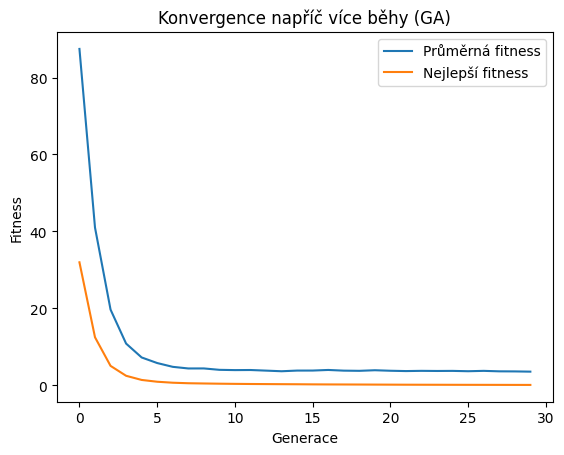

Konečná nejlepší fitness (průměr přes běhy): 0.1075971052226479


In [2]:
num_runs = 100
generations = 30
pop_size = 100
ind_size = 10
elite = 0.2
mutation_rate = 0.05
bounds = (-5.12, 5.12)

all_best_fitness = []
all_avg_fitness = []

for run in range(num_runs):
    #print(f"Run {run + 1}/{num_runs}")

    # Reset globalních proměnných pro každý běh
    individual_counter = 0
    crossover_log = []

    # Spuštění 1 běhu GA a získání fitness křivek
    _, best_fitness, avg_fitness = run_ga(
        pop_size, ind_size, generations,
        elite, mutation_rate, sphere, bounds
    )

    all_best_fitness.append(best_fitness)
    all_avg_fitness.append(avg_fitness)

# Převod na numpy pro výpočty
all_best_fitness = np.array(all_best_fitness)
all_avg_fitness = np.array(all_avg_fitness)

# Výpočet průměrných fitness napříč běhy
mean_best_fitness = np.mean(all_best_fitness, axis=0)
mean_avg_fitness = np.mean(all_avg_fitness, axis=0)

# Vykreslení
plt.plot(mean_avg_fitness, label="Průměrná fitness")
plt.plot(mean_best_fitness, label="Nejlepší fitness")
plt.legend()
plt.xlabel("Generace")
plt.ylabel("Fitness")
plt.title("Konvergence napříč více běhy (GA)")
plt.show()

print("Konečná nejlepší fitness (průměr přes běhy):", mean_best_fitness[-1])

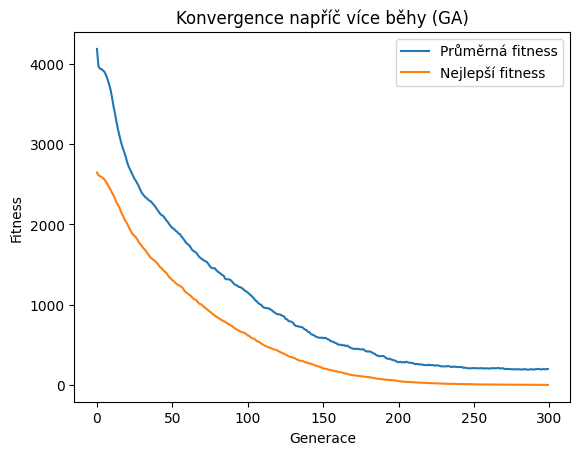

Konečná nejlepší fitness (průměr přes běhy): 2.151956561902716


In [3]:
num_runs = 100
generations = 300
pop_size = 100
ind_size = 10
elite = 0.2
mutation_rate = 0.05
bounds = (-500, 500)

all_best_fitness = []
all_avg_fitness = []

for run in range(num_runs):
    #print(f"Run {run + 1}/{num_runs}")

    # Reset globalních proměnných pro každý běh
    individual_counter = 0
    crossover_log = []

    # Spuštění 1 běhu GA a získání fitness křivek
    _, best_fitness, avg_fitness = run_ga(
        pop_size, ind_size, generations,
        elite, mutation_rate, schwefel, bounds
    )

    all_best_fitness.append(best_fitness)
    all_avg_fitness.append(avg_fitness)

# Převod na numpy pro výpočty
all_best_fitness = np.array(all_best_fitness)
all_avg_fitness = np.array(all_avg_fitness)

# Výpočet průměrných fitness napříč běhy
mean_best_fitness = np.mean(all_best_fitness, axis=0)
mean_avg_fitness = np.mean(all_avg_fitness, axis=0)

# Vykreslení
plt.plot(mean_avg_fitness, label="Průměrná fitness")
plt.plot(mean_best_fitness, label="Nejlepší fitness")
plt.legend()
plt.xlabel("Generace")
plt.ylabel("Fitness")
plt.title("Konvergence napříč více běhy (GA)")
plt.show()

print("Konečná nejlepší fitness (průměr přes běhy):", mean_best_fitness[-1])

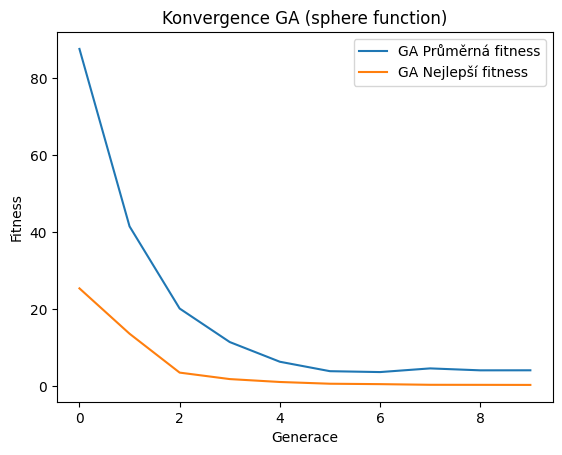

Nejlepší fitness v poslední generaci: 0.3243654238960075
Průměrné fitness v poslední generaci: 4.124019444988842


In [4]:
# Parametry
generations = 10
pop_size = 100
ind_size = 10
elite = 0.2
mutation_rate = 0.05
bounds = (-5.12, 5.12)

# Spuštění jednoho běhu GA
_, best_fitness, avg_fitness = run_ga(
    pop_size=pop_size,
    ind_size=ind_size,
    generations=generations,
    elite=elite,
    mutation_rate=mutation_rate,
    fitness_func=sphere,
    bounds=bounds
)

# Vykreslení konvergence
plt.plot(avg_fitness, label="GA Průměrná fitness")
plt.plot(best_fitness, label="GA Nejlepší fitness")
plt.legend()
plt.xlabel("Generace")
plt.ylabel("Fitness")
plt.title("Konvergence GA (sphere function)")
plt.show()


# Výstup výsledků
print("Nejlepší fitness v poslední generaci:", best_fitness[-1])
print("Průměrné fitness v poslední generaci:", avg_fitness[-1])

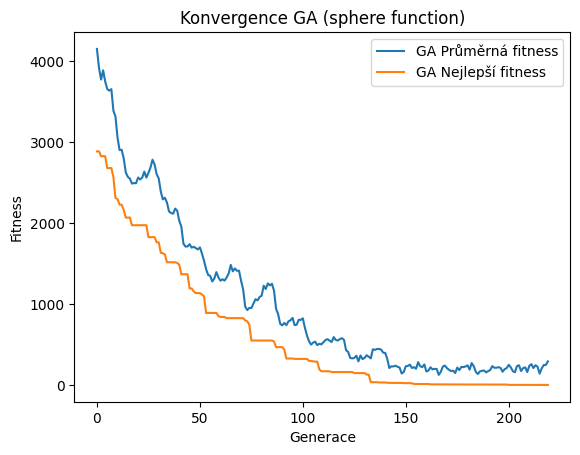

Nejlepší fitness v poslední generaci: 3.9206918105883233
Průměrné fitness v poslední generaci: 293.9815986517844


In [5]:
# Parametry
generations = 220
pop_size = 100
ind_size = 10
elite = 0.2
mutation_rate = 0.05
bounds = (-500, 500)

# Spuštění jednoho běhu GA
_, best_fitness, avg_fitness = run_ga(
    pop_size=pop_size,
    ind_size=ind_size,
    generations=generations,
    elite=elite,
    mutation_rate=mutation_rate,
    fitness_func=schwefel,
    bounds=bounds
)

# Vykreslení konvergence
plt.plot(avg_fitness, label="GA Průměrná fitness")
plt.plot(best_fitness, label="GA Nejlepší fitness")
plt.legend()
plt.xlabel("Generace")
plt.ylabel("Fitness")
plt.title("Konvergence GA (sphere function)")
plt.show()

# Výstup výsledků
print("Nejlepší fitness v poslední generaci:", best_fitness[-1])
print("Průměrné fitness v poslední generaci:", avg_fitness[-1])
